In [1]:
import pandas as pd
import numpy as np
import pickle
import os

from scipy.stats import kurtosis, skew
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import load_model
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz


Using TensorFlow backend.


In [2]:
LABELS = [
    "HAZMEI'S SEXY POSE (NEUTRAL)", 
    "HAZMEI'S FLYING KISS (WAVE HANDS)",
    "HYUN'S MAD DRIVING SKILLS (BUS DRIVING)",
    "ENCIK'S IPPT 2.4KM (FRONT BACK)",
    "HYUN'S BALLET DANCE (SIDE STEP)",
    "HAZMEI'S BELLY BOUNCE (JUMPING)"

] 

SAMPLING_RATE = 50
WINDOW_SIZE = 2
WINDOW_READINGS = int(WINDOW_SIZE * SAMPLING_RATE)
DATAPATH = 'data/'

ORDER = 3       # Order 3
CUTOFF = 7    # desired cutoff frequency of the filter in Hz (take max/60)
FILTER_SAMPLING_RATE = 20

In [3]:
def normalize_data(data):
    data_norm = (data - data.mean()) / (data.max() - data.min())
    return np.array(data_norm)

def frequency(data):
    fourier = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data), d=1/SAMPLING_RATE)
    
def magnitude(x, y, z):
    x_sq = np.power(x, 2)
    y_sq = np.power(y, 2)
    z_sq = np.power(z, 2)

    xyz_sq = x_sq + y_sq + z_sq

    xyz_mag = np.sqrt(xyz_sq)
    return xyz_mag

def rms(x, axis=None):
    return np.sqrt(np.mean(np.power(x, 2), axis=axis))

def feature_extraction(x, y, z):
    #'''
    #mean, std
    features = [np.mean(x), np.mean(y), np.mean(z), np.std(x), np.std(y), np.std(z)]
    #Median Absolute Deviation
    features.extend((np.mean(abs(x - features[0])), np.mean(abs(y - features[1])), np.mean(abs(z - features[2]))))
    #Jerk Signals mean, std, mad
    features.extend((np.mean(np.diff(x)), np.mean(np.diff(y)), np.mean(np.diff(z)), np.std(np.diff(x)), np.std(np.diff(y)), np.std(np.diff(z))))
    features.extend((np.mean(abs(np.diff(x) - features[9])), np.mean(abs(np.diff(y) - features[10])), np.mean(abs(np.diff(y) - features[11]))))
    #max, min
    features.extend((max(x), max(y), max(z), min(x), min(y), min(z)))
    #correlation
    features.extend((np.correlate(x, y)[0], np.correlate(x, z)[0], np.correlate(y, z)[0]))
    #energy
    features.extend((np.dot(x,x)/len(x), np.dot(y,y)/len(y), np.dot(z,z)/len(z)))
    #iqr
    #features.extend((np.subtract(*np.percentile(x, [75, 25])), np.subtract(*np.percentile(y, [75, 25])), np.subtract(*np.percentile(z, [75, 25]))))
    #Root Mean Square
    features.extend((rms(x), rms(y), rms(z)))
    #Skew, Kurtosis
    features.extend((skew(x), skew(y), skew(z), kurtosis(x), kurtosis(y), kurtosis(z)))
    #'''
    
    '''
    #Frequency Domain Features
    fourier_x = np.fft.fft(x)
    fourier_y = np.fft.fft(x)
    fourier_z = np.fft.fft(x)
    freqs = np.fft.fftfreq(WINDOW_READINGS)
    fourier_x = np.abs(fourier_x)
    fourier_y = np.abs(fourier_y)
    fourier_z = np.abs(fourier_z)
    #Mean Frequency, Skew, Kurtosis
    features.extend((np.mean(fourier_x), np.mean(fourier_y), np.mean(fourier_z)))
    features.extend((skew(fourier_x), skew(fourier_y), skew(fourier_z), kurtosis(fourier_x), kurtosis(fourier_y), kurtosis(fourier_z)))
    '''

    '''
    #Old Feature Extraction
    features = [np.mean(x), np.mean(y), np.mean(z), np.std(x), np.std(y), np.std(z)]
    #Median Absolute Deviation
    features.extend((np.mean(abs(x - features[0])), np.mean(abs(y - features[1])), np.mean(abs(z - features[2]))))
    #Jerk Signals
    features.extend((np.mean(np.diff(x)), np.mean(np.diff(y)), np.mean(np.diff(z)), np.std(np.diff(x)), np.std(np.diff(y)), np.std(np.diff(z))))
    features.extend((np.mean(abs(np.diff(x) - features[9])), np.mean(abs(np.diff(y) - features[10])), np.mean(abs(np.diff(y) - features[11]))))
    features.extend((skew(x), skew(y), skew(z), kurtosis(x), kurtosis(y), kurtosis(z)))
    features.extend((max(x), max(y), max(z), min(x), min(y), min(z)))
    '''
    
    return features

def add_noise(data):
    data_noise = data + np.random.uniform(size=len(data))
    data_noise = data_noise + np.random.laplace(loc=0.0, scale=1.0, size=len(data))
    return data_noise

def data_augmentation(X):
    X_noise = X
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            X_noise[i][:][j] = add_noise(X_noise[i][:][j])
    return np.concatenate((X, X_noise), axis=0)

def feature_selection(X, augmentData=False):
    data = []
    for i in range(X.shape[0]):
        features = []
        for j in range(0, X.shape[2], 3):
            x = [X[i][u][j] for u in range(X.shape[1])]
            y = [X[i][u][j+1] for u in range(X.shape[1])]
            z = [X[i][u][j+2] for u in range(X.shape[1])]
            
            if augmentData:
                x_noise = add_noise(x)
                y_noise = add_noise(y)
                z_noise = add_noise(z)
                features.append(feature_extraction(x_noise, y_noise, z_noise))
            else:
                features.append(feature_extraction(x, y, z))

        data.append(features)
    return np.array(data)

def feature_engineering(X, augmentData=False):
    if augmentData:
        return np.concatenate((feature_selection(X, False), feature_selection(X, True)), axis=0)
    else:
        return feature_selection(X, False)
    
def shitHotLP(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    v = butter_lowpass_filter(data, cutoff, fs, order)
    return v

def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def read_data(filename, label):
    raw_data = pd.read_csv(filename)
    raw_data = raw_data.iloc[100:-50, 0:9]
    raw_data = raw_data[:raw_data.shape[0]-(raw_data.shape[0]%WINDOW_READINGS)]
    #print(raw_data.shape)
    
    normalized_data = shitHotLP(raw_data, CUTOFF, FILTER_SAMPLING_RATE, ORDER)
    sampled_data = normalized_data.reshape(-1, WINDOW_READINGS, 9)
    #print(sampled_data.shape)
    return sampled_data, [label]*sampled_data.shape[0] 



def import_data(root_dirpath, test_data_size):
    X = np.zeros([1,WINDOW_READINGS,9])
    Xt = np.zeros([1,WINDOW_READINGS,9])
    y = []
    yt = []
    
    sub_directories = next(os.walk(root_dirpath))[1]    
    for sub_dir in sub_directories:
        files = next(os.walk(root_dirpath + sub_dir))[2]
        #print(files)
        count = 0;
        for file in files:
            if not file:
                continue
            temp_x, temp_y = read_data(root_dirpath + sub_dir + '/' + file, int(sub_dir))
            if (count < test_data_size):
                print(file)
                Xt = np.concatenate((Xt, temp_x), axis=0)
                yt = yt + temp_y
            else:
                X = np.concatenate((X, temp_x), axis=0)
                y = y + temp_y
            count = count + 1
            
    y = np.array(y)
    yt = np.array(yt)
    return X[1:], y, Xt[1:], yt


In [4]:
#Prediction

def predict(model):
    Y_output = model.predict(Xt)
    Y_pred = np.argmax(Y_output, axis=1)
    print(np.array(Y_pred))
    print("")
    print("Accuracy Rate:")
    print(metrics.accuracy_score(Yt, Y_pred))
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(Yt, Y_pred)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
    
    '''
    print("Precision: {}%".format(100*metrics.precision_score(Yt, Y_pred, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(Yt, Y_pred, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(Yt, Y_pred, average="weighted")))
    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    '''
    
    # Plot Results: 
    plt.figure(figsize=(12, 12))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(len(LABELS))
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    np.savetxt("data/accuracy.csv", [metrics.accuracy_score(Yt, Y_pred)], delimiter=",")
    np.savetxt("data/confusion_matrix.csv", metrics.confusion_matrix(Yt, Y_pred), delimiter=",")
    model.save('data/trained_nn_model.h5') 

In [5]:
X, Y, Xt, Yt = import_data(DATAPATH, 1)
print(X.shape)
print(Y.shape)
print(Xt.shape)
print(Yt.shape)

#print(X)
#print(Y)
print(Yt)

santos_natural.csv
Rahman_waving.csv
hyun_sidestep.csv
Rahman_frontback.csv
121017_hazmei_busdriver.csv
yz_jumping.csv
(2634, 100, 9)
(2634,)
(374, 100, 9)
(374,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5]


3


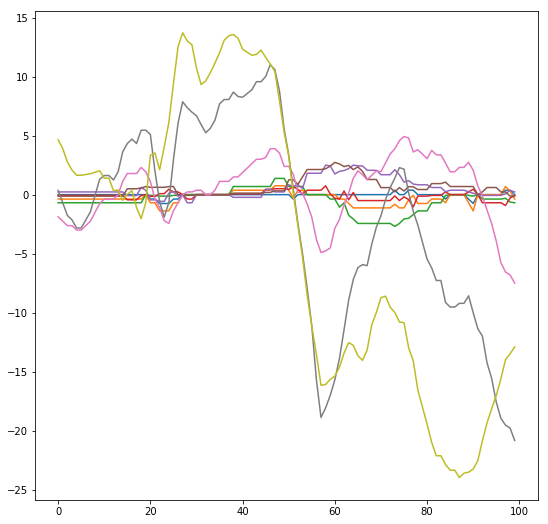

(9, 100)
5.67397639587


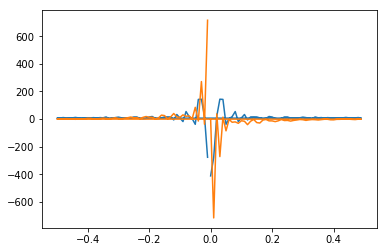

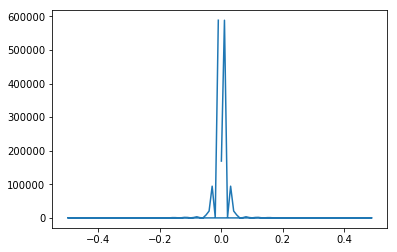

/Users/arshanrahman/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


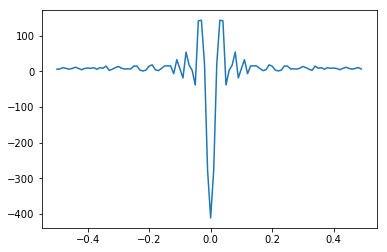

0.49
16290.9041709
4


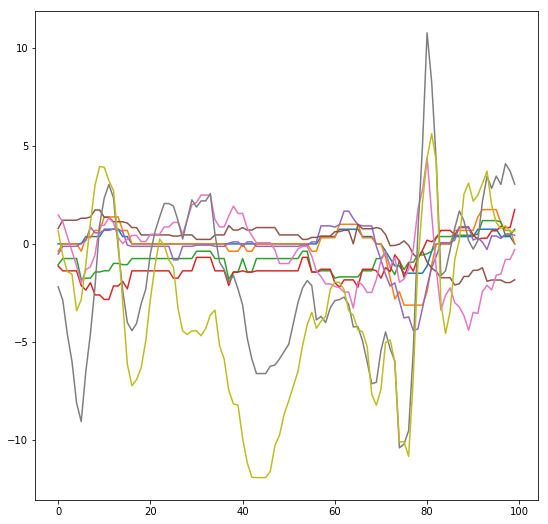

(9, 100)
52.473387864


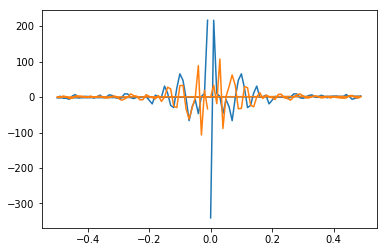

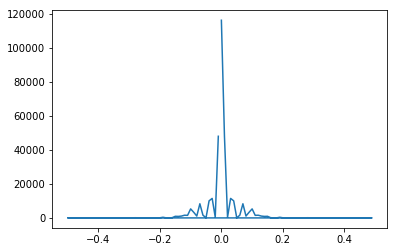

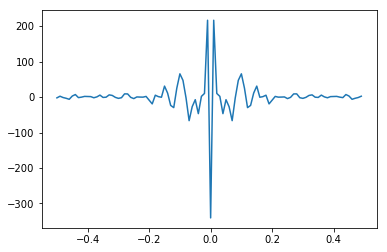

0.49
3107.12100607


In [6]:
#Plot Data
Size = Xt.shape[1];
Sample = [230, 180]
legends = ['acc1x', 'acc1y', 'acc1z', 'acc1x', 'acc2y', 'acc3z', 'gyrox', 'gyroy', 'gyroz']

for i in Sample:
    print(Yt[i])
    plt.figure(figsize=(9,9))
    plt.plot(list(range(Size)), Xt[i][:][:], label=legends )
    plt.show()

    temp = Xt[i][:][:].T
    print(temp.shape)
    #print(temp[0])
    print(np.correlate(temp[0], temp[1])[0])

    fourier = np.fft.fft(temp[8])
    freqs = np.fft.fftfreq(temp.shape[1])
    plt.plot(freqs, fourier.real, freqs, fourier.imag)
    plt.show()

    plt.plot(freqs, np.abs(fourier)**2)
    plt.show()

    idx = np.argsort(freqs)
    plt.plot(freqs[idx], fourier[idx])
    plt.show()
    print(max(freqs))
    print(np.mean(np.abs(fourier)**2))



#print(fourier)
#print(freqs)
#print(np.abs(fourier))
#print(np.mean(fourier))
#print(freqs)
#print(np.abs(freqs[0:51]))

In [7]:
#Raw Data with Data Augmentation
'''
X = data_augmentation(X)
Xt = data_augmentation(Xt)
Y = np.concatenate((Y, Y), axis=0)
Yt = np.concatenate((Yt, Yt), axis=0)
'''

#Feature Selection & Data Augmentation

#X = feature_engineering(X, False)
#Xt = feature_engineering(Xt, False)
#Y = np.concatenate((Y, Y), axis=0)
#Yt = np.concatenate((Yt, Yt), axis=0)





Yhot = to_categorical(Y)

print(X.shape)
print(Xt.shape)
print(Yhot.shape)
#print([Xt[i] for i in Sample])

np.savetxt("data/test_data_format.csv", Xt[0], delimiter=",")

#X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
#Xt = Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2])


(2634, 100, 9)
(374, 100, 9)
(2634, 6)


Train on 2370 samples, validate on 264 samples
Epoch 1/50
2370/2370 [==============================] - 1s - loss: 2.0337 - acc: 0.4494 - val_loss: 0.5244 - val_acc: 0.7955
Epoch 2/50
2370/2370 [==============================] - 0s - loss: 0.9681 - acc: 0.7173 - val_loss: 0.2298 - val_acc: 0.9091
Epoch 3/50
2370/2370 [==============================] - 0s - loss: 0.5356 - acc: 0.8270 - val_loss: 0.1612 - val_acc: 0.9621
Epoch 4/50
2370/2370 [==============================] - 0s - loss: 0.4034 - acc: 0.8620 - val_loss: 0.1627 - val_acc: 0.9583
Epoch 5/50
2370/2370 [==============================] - 0s - loss: 0.3401 - acc: 0.8764 - val_loss: 0.1936 - val_acc: 0.9432
Epoch 6/50
2370/2370 [==============================] - 0s - loss: 0.2731 - acc: 0.9084 - val_loss: 0.1372 - val_acc: 0.9659
Epoch 7/50
2370/2370 [==============================] - 0s - loss: 0.2266 - acc: 0.9262 - val_loss: 0.1213 - val_acc: 0.9811
Epoch 8/50
2370/2370 [==============================] - 0s - loss: 0.2119 - ac

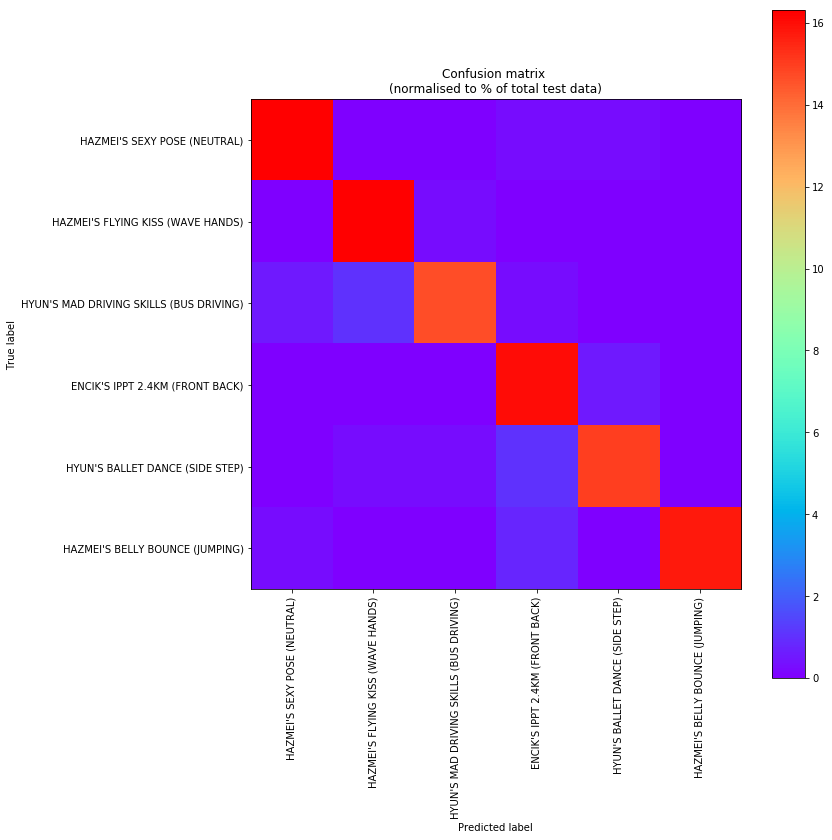

In [17]:
#Neural Network

data_dim = X.shape[2]
timesteps = X.shape[1]
num_classes = Yhot.shape[1]
b_size = 32

model = Sequential()
model.add(Dense(50, input_shape=(timesteps, data_dim), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Yhot, epochs=50, batch_size=b_size, validation_split=0.1, shuffle=True)
result = model.evaluate(X, Yhot)
print("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))

predict(model)

Train on 2370 samples, validate on 264 samples
Epoch 1/60
2370/2370 [==============================] - 1s - loss: 1.2432 - acc: 0.4945 - val_loss: 0.2734 - val_acc: 0.9470
Epoch 2/60
2370/2370 [==============================] - 1s - loss: 0.7453 - acc: 0.7599 - val_loss: 0.2552 - val_acc: 0.9242
Epoch 3/60
2370/2370 [==============================] - 1s - loss: 0.5064 - acc: 0.8616 - val_loss: 0.2462 - val_acc: 0.9280
Epoch 4/60
2370/2370 [==============================] - 1s - loss: 0.3508 - acc: 0.8810 - val_loss: 0.3507 - val_acc: 0.8674
Epoch 5/60
2370/2370 [==============================] - 1s - loss: 0.2975 - acc: 0.9038 - val_loss: 0.1876 - val_acc: 0.9432
Epoch 6/60
2370/2370 [==============================] - 1s - loss: 0.2762 - acc: 0.9114 - val_loss: 0.2345 - val_acc: 0.9394
Epoch 7/60
2370/2370 [==============================] - 1s - loss: 0.2357 - acc: 0.9304 - val_loss: 0.3354 - val_acc: 0.9053
Epoch 8/60
2370/2370 [==============================] - 1s - loss: 0.2157 - ac

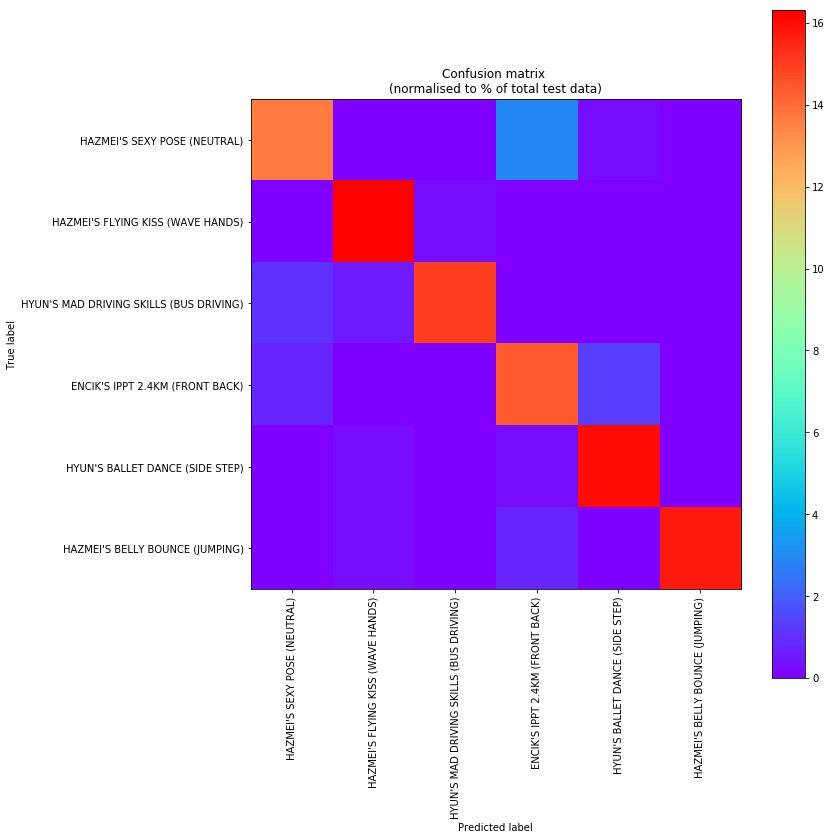

In [9]:
#CNN Neural Network

data_dim = X.shape[2]
timesteps = X.shape[1]
num_classes = Yhot.shape[1]
b_size = 32

model = Sequential()
model.add(Conv1D(64, 4, padding='valid', activation='relu', strides=1, input_shape=(timesteps, data_dim)))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Conv1D(64, 2, padding='valid', activation='relu', strides=1) )
model.add(Conv1D(32, 2, padding='valid', activation='relu', strides=1) )
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Conv1D(16, 1, padding='valid', activation='relu', strides=1) )
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Yhot, epochs=60, batch_size=b_size, validation_split=0.1, shuffle=True)
result = model.evaluate(X, Yhot)
print("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))

predict(model)

In [10]:
#LSTM Neural Network

'''data_dim = X.shape[2]
timesteps = X.shape[1]
num_classes = Yhot.shape[1]
b_size = 32

model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(timesteps, data_dim)))
model.add(LSTM(32, return_sequences=True))
#model.add(LSTM(32, return_sequences=True))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Yhot, epochs=10, batch_size=b_size, validation_split=0.1, shuffle=True)
result = model.evaluate(X, Yhot)
print("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))

predict(model)'''

'data_dim = X.shape[2]\ntimesteps = X.shape[1]\nnum_classes = Yhot.shape[1]\nb_size = 32\n\nmodel = Sequential()\nmodel.add(LSTM(32, return_sequences=True, input_shape=(timesteps, data_dim)))\nmodel.add(LSTM(32, return_sequences=True))\n#model.add(LSTM(32, return_sequences=True))\nmodel.add(Flatten())\nmodel.add(Dense(num_classes, activation=\'softmax\'))\n\nmodel.compile(loss=\'categorical_crossentropy\',\n              optimizer=\'adam\',\n              metrics=[\'accuracy\'])\n\nmodel.fit(X, Yhot, epochs=10, batch_size=b_size, validation_split=0.1, shuffle=True)\nresult = model.evaluate(X, Yhot)\nprint("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))\nprint("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))\n\npredict(model)'

In [11]:
'''
raw_data = pd.read_csv('data/sample_data_format.csv', skiprows=range(0, 7))
print(raw_data.shape)
cropped_data = raw_data.values.reshape(-1, 40, 9)
print(cropped_data.shape)
print(cropped_data)
pickle.dump(cropped_data, open('data/cropped_data_format.pkl', 'wb'))
np.savetxt("data/cropped_data_format_2.csv", cropped_data[2], delimiter=",")
'''

'\nraw_data = pd.read_csv(\'data/sample_data_format.csv\', skiprows=range(0, 7))\nprint(raw_data.shape)\ncropped_data = raw_data.values.reshape(-1, 40, 9)\nprint(cropped_data.shape)\nprint(cropped_data)\npickle.dump(cropped_data, open(\'data/cropped_data_format.pkl\', \'wb\'))\nnp.savetxt("data/cropped_data_format_2.csv", cropped_data[2], delimiter=",")\n'